### Pre-Procesado de datos

In [1]:
import os # Sistema operativo

import cv2 # Computer Vision 2 Librería

import numpy as np # Algebra lineal

from sklearn.utils import shuffle # Para mezclar los datos

import pandas as pd # procesamiento de datos

import matplotlib.pyplot as plt # proyección grafica de datos

from random import randint # libreria de aleatoriedad

import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\rafra\.conda\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### Consiguiendo las imagenes

In [2]:
def get_images(directory):
    Images = []
    Labels = []
    
    label = 0
    # Directorio principal donde cada etiqueta de clase es presente como el nombre de un folder
    for labels in os.listdir(directory):
        if labels == 'NORMAL':
            label = 0
        elif labels == 'PNEUMONIA':
            label = 1
        
        # Extraer el nombre del archivo de la imagen desde el nombre de la clase qu elo contiene
        for image_file in os.listdir(directory+labels):
            #leyendo la imagen (OpenCV)
            image = cv2.imread(directory+labels+r'/'+image_file)
            # Redimensionando la imagen
            image = cv2.resize(image, (150,150))
            
            Images.append(image)
            Labels.append(label)
    
    # Revolver las imagenes
    return shuffle(Images, Labels, random_state=817328462)            

In [3]:
# Definiendo el diccionario de clases
def get_classlabel(class_code):
    labels = {0:'NORMAL', 1:'PNEUMONIA'}
    return labels[class_code]

In [4]:
# Extrae las imagens de entrenamiento de las carpetas
Images, Labels = get_images('input/chest_xray/train/')

In [5]:
# Unimos par con par las imagenes y las etiquetas
result = zip(Images, Labels)

# Lista de donde estara la información de las imagenes
train_data = []
for img in result:
    train_data.append(img)

# Definir el dataframe de las imagenes que tenemos en la lista 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

### ¿ Cuantos ejemplos por cada tipo de imagen hay en el dataset ?

1    3875
0    1341
Name: label, dtype: int64


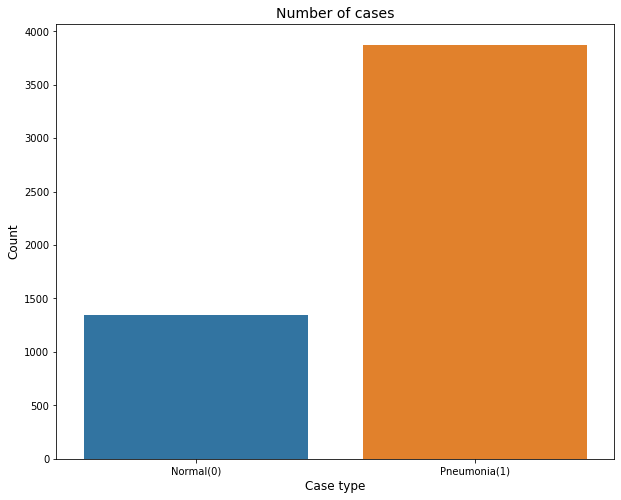

In [6]:
# Obtener el conteo de cada clase
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

### Analisis de los datos

<font color=green>Como puede ver, los datos están altamente desequilibrados. Tenemos casi tres casos de neumonía aquí en comparación con los casos normales. Esta situación es muy normal cuando se trata de datos médicos. Los datos siempre estarán desequilibrados. o habrá demasiados casos normales o habrá demasiados casos con la enfermedad.

Veamos cómo un caso normal es diferente al de un caso de neumonía. Observaremos algunas muestras de nuestros datos de entrenamiento.</font>

In [7]:
Images = np.array(Images) # Se convierten la lista de imagenes en un array de numpy
Labels = np.array(Labels)

In [8]:
# Una vez cargadas podemos analizar los datos
print("Tamaño de las imagenes", Images.shape)

Tamaño de las imagenes (5216, 150, 150, 3)


Tenemos entonces 5216 imagenes para el entrenamiento de 150X150 en 3 canales de color.

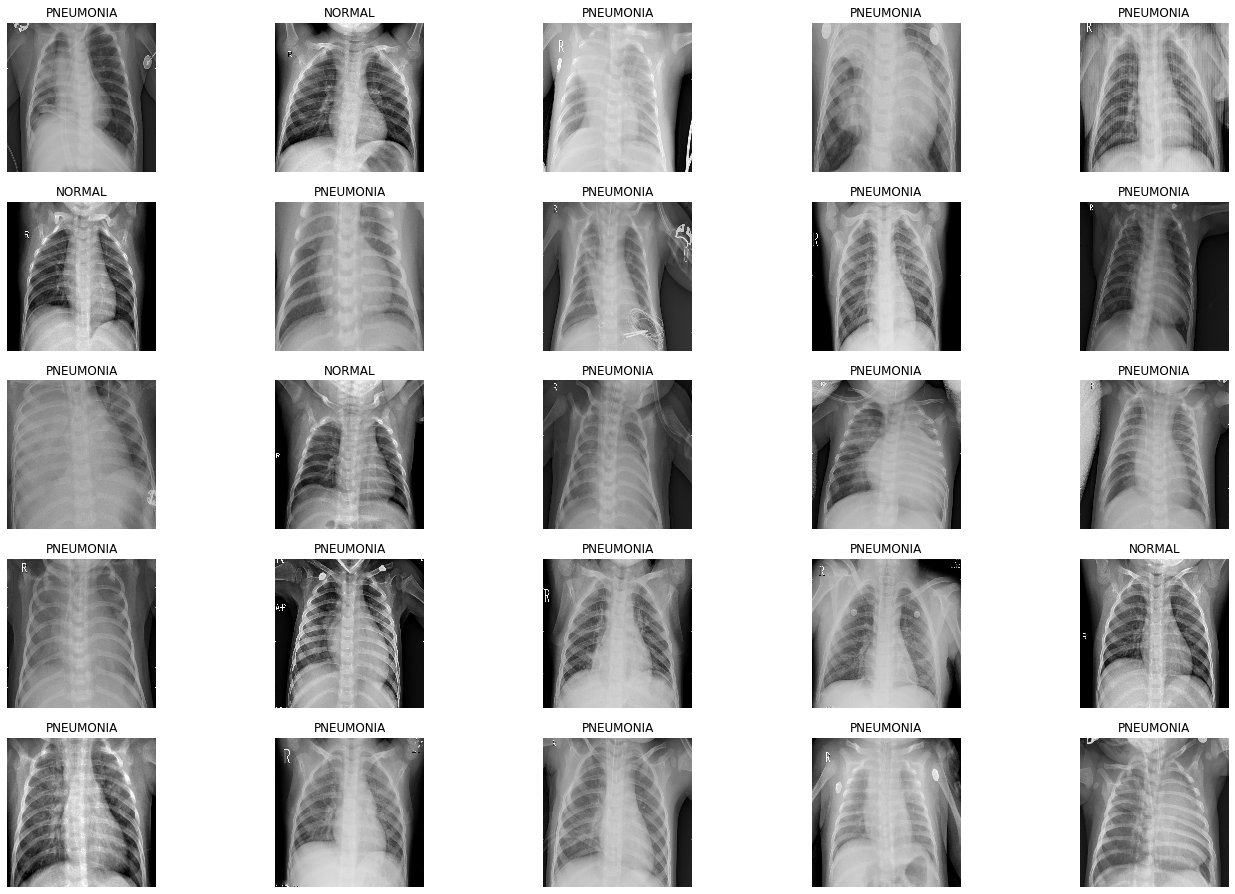

In [9]:
# Podemos observarlas
f, ax = plt.subplots(5,5)
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rdn_number = randint(0, len(Images))
        ax[i, j].imshow(Images[rdn_number])
        ax[i, j].set_title(get_classlabel(Labels[rdn_number]))
        ax[i, j].axis('off')

### Crar el modelo

In [10]:
# creación del modelo
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer

In [11]:
# tipo de modelo
model = Models.Sequential()

**Hyper parámetros de la capa de la RNC:**

    Filtros: 32
    Tamaño del kernel: 3
    padding: same
    Función de Activación: relu

In [12]:
# Capa 1: Entrada
model.add(Layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        padding='same', 
                        activation='relu',
                        input_shape=[150,150,3]))

**Hyper parámetros de la capa de la RNC:**

    Filtros: 32
    Tamaño del kernel: 3
    padding: same
    Función de Activación: relu

**Hyper parámetros de la capa de MaxPool:**

    pool_size: 2
    strides: 2
    padding: valid

In [13]:
# Capa 2: Convolucional 
model.add(Layers.Conv2D(filters=32, 
                        kernel_size=3, 
                        padding="same", 
                        activation="relu"))

In [14]:
model.add(Layers.MaxPool2D(pool_size=2, 
                           strides=2, 
                           padding='valid'))

**Hyper parámetros de la capa de la RNC:**

    Filtros: 64
    Tamaño del kernel: 3
    padding: same
    Función de Activación: relu (Rectificadora lineal unitaria)

In [15]:
# Capa 3: capa convolucional con el doble de filtros
model.add(Layers.Conv2D(filters=64, 
                        kernel_size=3, 
                        padding="same", 
                        activation="relu"))

In [16]:
# Capa 4 : Capa convolucional Conv2D de padding same y la Capa convolucional MaxPool2D padding valido
model.add(Layers.Conv2D(filters=64, 
                        kernel_size=3, 
                        padding='same', 
                        activation='relu'))

In [17]:
model.add(Layers.MaxPool2D(pool_size=2, 
                           strides=2, 
                           padding='valid'))

In [18]:
# flattening
model.add(Layers.Flatten())

In [19]:
# Capa 5 totalmente conectada
model.add(Layers.Dense(units=128, 
                       activation='relu'))

**Añadir la capa de salida**

    Hyper parámetros de la capa totalmente conectada:

    units/neurons: 2 (number of classes)
    activation: softmax

In [20]:
model.add(Layers.Dense(units=1, 
                       activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0

In [22]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Pre-analisis
    1 => PNEUMONIA    3875
    0 => NORMAL   1341

<font color=green>Las clases están desequilibradas, por lo tanto, la precisión de la validación no será una buena métrica para analizar el rendimiento del modelo. También tendremos que tener en cuenta la matriz de precisión, recuperación y confusión.</font>

In [46]:
# Importamos ReduceLROnPlateau para reducir el ratio de aprendizaje
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

<font color=green>Callbacks para reducir la tasa de aprendizaje a tiempo después de monitorear una cantidad.</font>

In [47]:
# Definimos un checkpoin donde guardaremos los pesos finales de red entrenada
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### Cargare adicionalmente el set de testing

In [44]:
test_images, test_labels = get_images('input/chest_xray/test/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### Entrenamiento del modelo

In [48]:
trained = model.fit(Images, Labels,  # training datos
                    validation_data =(test_images, test_labels), # testing datos
                    callbacks=[lr_reduce,checkpoint] , # reducir ratio de aprendizaje
                    epochs=10) # 10 epochs

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5184/5216 [============================>.] - ETA: 1s - loss: 0.0528 - accuracy: 0.9967
Epoch 00001: val_accuracy improved from -inf to 0.73558, saving model to weights.hdf5
5216/5216 [==============================] - 293s 56ms/sample - loss: 0.0525 - accuracy: 0.9967 - val_loss: 19.1055 - val_accuracy: 0.7356
Epoch 2/10
5184/5216 [============================>.] - ETA: 1s - loss: 0.0479 - accuracy: 0.9973
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_accuracy did not improve from 0.73558
5216/5216 [==============================] - 320s 61ms/sample - loss: 0.0476 - accuracy: 0.9973 - val_loss: 17.0532 - val_accuracy: 0.7212
Epoch 3/10
5184/5216 [============================>.] - ETA: 1s - loss: 8.9487e-06 - accuracy: 1.0000
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_accuracy did not improve from 0.73558
5216/5216 [======

In [59]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

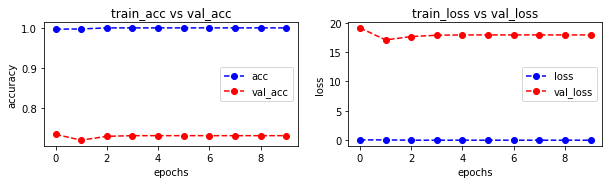

In [60]:
plot_accuracy_loss(trained)

In [78]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

624/624 [==============================] - 7s 12ms/sample - loss: 17.9071 - accuracy: 0.7324


### Ver la exactitud del modelo

In [79]:
print("Exactitud de las pruebas: {}".format(test_accuracy))
print("Función de perdidad: {}".format(test_loss))

Exactitud de las pruebas: 0.7323718070983887
Función de perdidad: 17.907075099456005


### Predicción de las imagenes

In [80]:
import matplotlib.gridspec as gridspec

In [81]:
pred_images, no_labels = get_images('input/chest_xray/val/')
pred_images = np.array(pred_images)
pred_images.shape

(16, 150, 150, 3)